In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

In [2]:
import tensorflow as tf
import keras
from keras.models import Sequential, Model
from keras import layers, applications, optimizers
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation,GlobalMaxPooling2D
from keras.preprocessing.image import ImageDataGenerator, load_img

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
import cv2
import random

In [3]:
tf.debugging.set_log_device_placement(True)

a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
c = tf.matmul(a, b)
print(c)

Executing op MatMul in device /job:localhost/replica:0/task:0/device:GPU:0
tf.Tensor(
[[22. 28.]
 [49. 64.]], shape=(2, 2), dtype=float32)


In [4]:
image_size = 224
batch_size = 32
freeze_num = 5
num_classes = 5
save_model_filename = 'cassava_transfer.h5'

In [5]:
train = pd.read_csv('./cassava-leaf-disease-classification/train.csv')

In [6]:
train.head(10)

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3
5,1000837476.jpg,3
6,1000910826.jpg,2
7,1001320321.jpg,0
8,1001723730.jpg,4
9,1001742395.jpg,3


In [7]:
data = {"0":"Cassava Bacterial Blight (CBB)",
        "1":"Cassava Brown Streak Disease (CBSD)",
        "2":"Cassava Green Mottle (CGM)",
        "3":"Cassava Mosaic Disease (CMD)",
        "4":"Healthy"}

disease_label = pd.DataFrame(data=data.values(),index=data.keys(),columns=['Disease_Name'])

In [8]:
disease_label

,Disease_Name
0,Cassava Bacterial Blight (CBB)
1,Cassava Brown Streak Disease (CBSD)
2,Cassava Green Mottle (CGM)
3,Cassava Mosaic Disease (CMD)
4,Healthy


In [9]:
train_path = './cassava-leaf-disease-classification/train_images'
test_path = './cassava-leaf-disease-classification/test_images'

In [10]:
def image_path(image):
    return os.path.join(train_path,image)

train['image_id'] = train['image_id'].apply(image_path)

In [11]:
train.head(10)

,image_id,label
0,./cassava-leaf-disease-classification/train_im...,0
1,./cassava-leaf-disease-classification/train_im...,3
2,./cassava-leaf-disease-classification/train_im...,1
3,./cassava-leaf-disease-classification/train_im...,1
4,./cassava-leaf-disease-classification/train_im...,3
5,./cassava-leaf-disease-classification/train_im...,3
6,./cassava-leaf-disease-classification/train_im...,2
7,./cassava-leaf-disease-classification/train_im...,0
8,./cassava-leaf-disease-classification/train_im...,4
9,./cassava-leaf-disease-classification/train_im...,3


In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21397 entries, 0 to 21396
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image_id  21397 non-null  object
 1   label     21397 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 334.5+ KB


In [13]:
train['label'] = train['label'].astype('str')

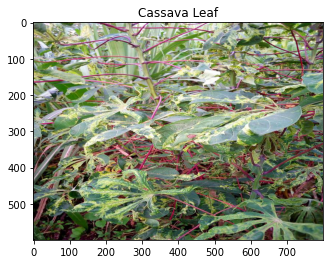

In [14]:
# display random image

index = np.random.randint(0,len(train))

plt.imshow(imread(train['image_id'][index]))
plt.title('Cassava Leaf')

plt.show()

C:\Users\pomat\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


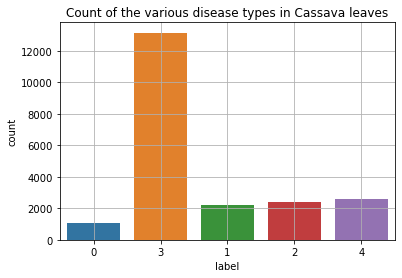

In [15]:
import seaborn as sns

sns.countplot(train['label'])
plt.title('Count of the various disease types in Cassava leaves')
plt.grid()
plt.show()

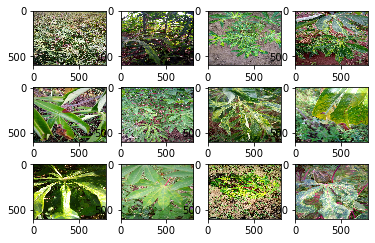

In [16]:
n_rows = 3
n_cols = 4

for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index+1)
        
        leaf_img = np.random.randint(0, len(train))
        img = imread(train.iloc[leaf_img]['image_id'])
        
        plt.imshow(img, cmap='binary',interpolation='nearest')

In [17]:
image_generator = ImageDataGenerator(rotation_range=15, horizontal_flip=True, vertical_flip=True,
                                     shear_range=0.2, zoom_range=0.2, brightness_range=[0.1,0.3], fill_mode='nearest', 
                                     validation_split=0.2, rescale = 1./255,
                                     preprocessing_function=tf.keras.applications.vgg16.preprocess_input)

In [18]:
train_generator = image_generator.flow_from_dataframe(dataframe=train, directory=None, x_col='image_id', y_col='label',
                                                      subset='training', color_mode='rgb', batch_size=batch_size, seed=42,
                                                      shuffle=True, class_mode='categorical', target_size=(image_size,image_size))

Found 17118 validated image filenames belonging to 5 classes.


In [19]:
validation_generator = image_generator.flow_from_dataframe(dataframe=train, directory=None, x_col='image_id', y_col='label',
                                                   subset='validation', color_mode='rgb', batch_size=batch_size, seed=42,
                                                   shuffle=False, class_mode='categorical', target_size=(image_size,image_size))

Found 4279 validated image filenames belonging to 5 classes.


In [20]:
%load_ext tensorboard

import datetime

In [21]:
model = keras.models.load_model('resnet50.h5')

Executing op TruncatedNormal in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/re

Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op TruncatedNormal in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localh

Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalN

Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localho

Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device 

In [22]:
len(model.layers)

25

In [23]:
# freeze first {freeze_num} layers

for i in range(freeze_num):
    model.layers[i].trainable = False

In [24]:
# make the next layers trainable except the last layer

for i in range(freeze_num, len(model.layers)-1):
    model.layers[i].trainable = True

In [25]:
# add one new layer

layer = model.layers[len(model.layers)-1].output
layer = Dense(num_classes, activation='softmax')(layer)

model = Model(inputs=model.input, outputs=layer)

Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica

In [26]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, clipnorm=1.),
    metrics=['accuracy']
)

Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:lo

In [27]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block0_conv0 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block0_conv1 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block0_pooling (MaxPooling2D (None, 112, 112, 64)      0         
_________________________________________________________________
block1_conv0 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block1_pooling (MaxPooling2D (None, 56, 56, 128)      

In [28]:
log_dir = "logs/cassava_transfer/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [29]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
model_checkpoint = ModelCheckpoint(save_model_filename, monitor='val_loss', mode='min', verbose=1, save_best_only=True, save_weights_only=False)

In [30]:
from keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.00001)

In [ ]:
epoch = 100

history = model.fit(
    train_generator,
    epochs=epoch,
    validation_data=validation_generator,
    verbose=1,
    callbacks=[tensorboard_callback, early_stopping, model_checkpoint, reduce_lr]
)

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op DestroyResourceOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DestroyResourceOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DestroyResourceOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DestroyResourceOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op SummaryWriter in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op CreateSummaryFileWriter in device /job:localhost/replica:0/task:0/device:CPU:0
E

Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localho

Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /j

117/535 [=====>........................] - ETA: 3:22 - loss: 1.2540 - accuracy: 0.5980Executing op __inference_train_function_3146 in device /job:localhost/replica:0/task:0/device:GPU:0


205/535 [==========>...................] - ETA: 2:41 - loss: 1.2329 - accuracy: 0.6060Executing op __inference_train_function_3146 in device /job:localhost/replica:0/task:0/device:GPU:0


293/535 [===============>..............] - ETA: 1:57 - loss: 1.2256 - accuracy: 0.6070Executing op __inference_train_function_3146 in device /job:localhost/replica:0/task:0/device:GPU:0


381/535 [====================>.........] - ETA: 1:14 - loss: 1.2212 - accuracy: 0.6078Executing op __inference_train_function_3146 in device /job:localhost/replica:0/task:0/device:GPU:0


469/535 [=========================>....] - ETA: 32s - loss: 1.2195 - accuracy: 0.6072Executing op __inference_train_function_3146 in device /job:localhost/replica:0/task:0/device:GPU:0


535/535 [==============================] - ETA: 0s - loss: 1.2155 - accuracy: 0.6084Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op SummaryWriter in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op CreateSummaryFileWriter in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Opt

Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:loc

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /j

119/535 [=====>........................] - ETA: 2:41 - loss: 1.1828 - accuracy: 0.6163Executing op __inference_train_function_3146 in device /job:localhost/replica:0/task:0/device:GPU:0


207/535 [==========>...................] - ETA: 2:08 - loss: 1.1776 - accuracy: 0.6202Executing op __inference_train_function_3146 in device /job:localhost/replica:0/task:0/device:GPU:0


295/535 [===============>..............] - ETA: 1:34 - loss: 1.1855 - accuracy: 0.6156Executing op __inference_train_function_3146 in device /job:localhost/replica:0/task:0/device:GPU:0


383/535 [====================>.........] - ETA: 59s - loss: 1.1890 - accuracy: 0.6135 Executing op __inference_train_function_3146 in device /job:localhost/replica:0/task:0/device:GPU:0


471/535 [=========================>....] - ETA: 25s - loss: 1.1873 - accuracy: 0.6148Executing op __inference_train_function_3146 in device /job:localhost/replica:0/task:0/device:GPU:0


535/535 [==============================] - ETA: 0s - loss: 1.1878 - accuracy: 0.6146Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op DeleteIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:G

Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op 

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /j

Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
535/535 [==============================] - 271s 506ms/step - loss: 1.1878 - accuracy: 0.6146 - val_loss: 1.1786 - val_accuracy: 0.6165
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op DeleteIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /

169/535 [========>.....................] - ETA: 2:23 - loss: 1.1927 - accuracy: 0.6108Executing op __inference_train_function_3146 in device /job:localhost/replica:0/task:0/device:GPU:0


257/535 [=============>................] - ETA: 1:49 - loss: 1.1897 - accuracy: 0.6121Executing op __inference_train_function_3146 in device /job:localhost/replica:0/task:0/device:GPU:0


345/535 [==================>...........] - ETA: 1:14 - loss: 1.1863 - accuracy: 0.6135Executing op __inference_train_function_3146 in device /job:localhost/replica:0/task:0/device:GPU:0


433/535 [=======================>......] - ETA: 39s - loss: 1.1860 - accuracy: 0.6140Executing op __inference_train_function_3146 in device /job:localhost/replica:0/task:0/device:GPU:0


521/535 [============================>.] - ETA: 5s - loss: 1.1887 - accuracy: 0.6130Executing op __inference_train_function_3146 in device /job:localhost/replica:0/task:0/device:GPU:0


535/535 [==============================] - ETA: 0s - loss: 1.1856 - accuracy: 0.6146Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op DeleteIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:G

Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DeleteIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteScalarSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteScala

Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

143/535 [=======>......................] - ETA: 2:31 - loss: 1.1796 - accuracy: 0.6163Executing op __inference_train_function_3146 in device /job:localhost/replica:0/task:0/device:GPU:0


231/535 [===========>..................] - ETA: 1:58 - loss: 1.1733 - accuracy: 0.6218Executing op __inference_train_function_3146 in device /job:localhost/replica:0/task:0/device:GPU:0


319/535 [================>.............] - ETA: 1:24 - loss: 1.1807 - accuracy: 0.6176Executing op __inference_train_function_3146 in device /job:localhost/replica:0/task:0/device:GPU:0


407/535 [=====================>........] - ETA: 50s - loss: 1.1815 - accuracy: 0.6172Executing op __inference_train_function_3146 in device /job:localhost/replica:0/task:0/device:GPU:0


495/535 [==========================>...] - ETA: 15s - loss: 1.1827 - accuracy: 0.6162Executing op __inference_train_function_3146 in device /job:localhost/replica:0/task:0/device:GPU:0


535/535 [==============================] - ETA: 0s - loss: 1.1854 - accuracy: 0.6146Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op DeleteIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:G

Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in devic

Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

118/535 [=====>........................] - ETA: 2:42 - loss: 1.1899 - accuracy: 0.6123Executing op __inference_train_function_3146 in device /job:localhost/replica:0/task:0/device:GPU:0


206/535 [==========>...................] - ETA: 2:08 - loss: 1.1814 - accuracy: 0.6183Executing op __inference_train_function_3146 in device /job:localhost/replica:0/task:0/device:GPU:0


294/535 [===============>..............] - ETA: 1:34 - loss: 1.1766 - accuracy: 0.6200Executing op __inference_train_function_3146 in device /job:localhost/replica:0/task:0/device:GPU:0


382/535 [====================>.........] - ETA: 1:00 - loss: 1.1835 - accuracy: 0.6161Executing op __inference_train_function_3146 in device /job:localhost/replica:0/task:0/device:GPU:0


470/535 [=========================>....] - ETA: 25s - loss: 1.1837 - accuracy: 0.6160Executing op __inference_train_function_3146 in device /job:localhost/replica:0/task:0/device:GPU:0


535/535 [==============================] - ETA: 0s - loss: 1.1856 - accuracy: 0.6146Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op DeleteIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:G

Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /j

Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
535/535 [==============================] - 270s 505ms/step - loss: 1.1856 - accuracy: 0.6146 - val_loss: 1.1780 - val_accuracy: 0.6165
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op DeleteIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localh

125/535 [======>.......................] - ETA: 2:40 - loss: 1.1738 - accuracy: 0.6205Executing op __inference_train_function_3146 in device /job:localhost/replica:0/task:0/device:GPU:0


213/535 [==========>...................] - ETA: 2:06 - loss: 1.1735 - accuracy: 0.6203Executing op __inference_train_function_3146 in device /job:localhost/replica:0/task:0/device:GPU:0


301/535 [===============>..............] - ETA: 1:32 - loss: 1.1815 - accuracy: 0.6164Executing op __inference_train_function_3146 in device /job:localhost/replica:0/task:0/device:GPU:0


389/535 [====================>.........] - ETA: 57s - loss: 1.1844 - accuracy: 0.6148Executing op __inference_train_function_3146 in device /job:localhost/replica:0/task:0/device:GPU:0


477/535 [=========================>....] - ETA: 22s - loss: 1.1908 - accuracy: 0.6120Executing op __inference_train_function_3146 in device /job:localhost/replica:0/task:0/device:GPU:0


535/535 [==============================] - ETA: 0s - loss: 1.1855 - accuracy: 0.6146Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op DeleteIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:G

Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DeleteIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteScalarSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteScala

Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

143/535 [=======>......................] - ETA: 2:33 - loss: 1.1883 - accuracy: 0.6117Executing op __inference_train_function_3146 in device /job:localhost/replica:0/task:0/device:GPU:0


231/535 [===========>..................] - ETA: 1:59 - loss: 1.1872 - accuracy: 0.6130Executing op __inference_train_function_3146 in device /job:localhost/replica:0/task:0/device:GPU:0


319/535 [================>.............] - ETA: 1:24 - loss: 1.1891 - accuracy: 0.6128Executing op __inference_train_function_3146 in device /job:localhost/replica:0/task:0/device:GPU:0


407/535 [=====================>........] - ETA: 50s - loss: 1.1856 - accuracy: 0.6144Executing op __inference_train_function_3146 in device /job:localhost/replica:0/task:0/device:GPU:0


495/535 [==========================>...] - ETA: 15s - loss: 1.1859 - accuracy: 0.6142Executing op __inference_train_function_3146 in device /job:localhost/replica:0/task:0/device:GPU:0


535/535 [==============================] - ETA: 0s - loss: 1.1855 - accuracy: 0.6146Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op DeleteIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:G

Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in devic

Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /j

149/535 [=======>......................] - ETA: 2:29 - loss: 1.1852 - accuracy: 0.6158Executing op __inference_train_function_3146 in device /job:localhost/replica:0/task:0/device:GPU:0


237/535 [============>.................] - ETA: 1:55 - loss: 1.1905 - accuracy: 0.6122Executing op __inference_train_function_3146 in device /job:localhost/replica:0/task:0/device:GPU:0


325/535 [=================>............] - ETA: 1:21 - loss: 1.1824 - accuracy: 0.6167Executing op __inference_train_function_3146 in device /job:localhost/replica:0/task:0/device:GPU:0


413/535 [======================>.......] - ETA: 47s - loss: 1.1773 - accuracy: 0.6190Executing op __inference_train_function_3146 in device /job:localhost/replica:0/task:0/device:GPU:0


501/535 [===========================>..] - ETA: 13s - loss: 1.1834 - accuracy: 0.6155Executing op __inference_train_function_3146 in device /job:localhost/replica:0/task:0/device:GPU:0


535/535 [==============================] - ETA: 0s - loss: 1.1851 - accuracy: 0.6146Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op DeleteIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:G

Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlushSummaryWriter in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlushSummaryWriter in device /job:localhost/replica:0/task:0/device:CPU:0

Epoch 00008: val_loss did not improve from 1.17761
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
535/535 [==============================] - 266s 497ms/step - loss: 1.1851 - accuracy: 0.6146 - val_loss: 1.1783 - val_accuracy: 0.6165
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op DeleteIterator in device /job:localhost/re

168/535 [========>.....................] - ETA: 2:23 - loss: 1.1821 - accuracy: 0.6178Executing op __inference_train_function_3146 in device /job:localhost/replica:0/task:0/device:GPU:0


256/535 [=============>................] - ETA: 1:48 - loss: 1.1864 - accuracy: 0.6145Executing op __inference_train_function_3146 in device /job:localhost/replica:0/task:0/device:GPU:0


344/535 [==================>...........] - ETA: 1:14 - loss: 1.1850 - accuracy: 0.6155Executing op __inference_train_function_3146 in device /job:localhost/replica:0/task:0/device:GPU:0


432/535 [=======================>......] - ETA: 40s - loss: 1.1874 - accuracy: 0.6134Executing op __inference_train_function_3146 in device /job:localhost/replica:0/task:0/device:GPU:0


520/535 [============================>.] - ETA: 5s - loss: 1.1845 - accuracy: 0.6152Executing op __inference_train_function_3146 in device /job:localhost/replica:0/task:0/device:GPU:0


535/535 [==============================] - ETA: 0s - loss: 1.1857 - accuracy: 0.6146Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op DeleteIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:G

Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DeleteIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteScalarSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
E

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op 

 99/535 [====>.........................] - ETA: 2:48 - loss: 1.2105 - accuracy: 0.6032Executing op __inference_train_function_3146 in device /job:localhost/replica:0/task:0/device:GPU:0


187/535 [=========>....................] - ETA: 2:15 - loss: 1.2038 - accuracy: 0.6051Executing op __inference_train_function_3146 in device /job:localhost/replica:0/task:0/device:GPU:0


275/535 [==============>...............] - ETA: 1:41 - loss: 1.1888 - accuracy: 0.6126Executing op __inference_train_function_3146 in device /job:localhost/replica:0/task:0/device:GPU:0


363/535 [===================>..........] - ETA: 1:07 - loss: 1.1931 - accuracy: 0.6106Executing op __inference_train_function_3146 in device /job:localhost/replica:0/task:0/device:GPU:0


451/535 [========================>.....] - ETA: 32s - loss: 1.1904 - accuracy: 0.6124Executing op __inference_train_function_3146 in device /job:localhost/replica:0/task:0/device:GPU:0


535/535 [==============================] - ETA: 0s - loss: 1.1857 - accuracy: 0.6146Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op DeleteIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:G

Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in devic

Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /j

149/535 [=======>......................] - ETA: 2:30 - loss: 1.1866 - accuracy: 0.6135Executing op __inference_train_function_3146 in device /job:localhost/replica:0/task:0/device:GPU:0


237/535 [============>.................] - ETA: 1:56 - loss: 1.1957 - accuracy: 0.6085Executing op __inference_train_function_3146 in device /job:localhost/replica:0/task:0/device:GPU:0


325/535 [=================>............] - ETA: 1:22 - loss: 1.1921 - accuracy: 0.6111Executing op __inference_train_function_3146 in device /job:localhost/replica:0/task:0/device:GPU:0


413/535 [======================>.......] - ETA: 47s - loss: 1.1895 - accuracy: 0.6127Executing op __inference_train_function_3146 in device /job:localhost/replica:0/task:0/device:GPU:0


501/535 [===========================>..] - ETA: 13s - loss: 1.1849 - accuracy: 0.6146Executing op __inference_train_function_3146 in device /job:localhost/replica:0/task:0/device:GPU:0


535/535 [==============================] - ETA: 0s - loss: 1.1854 - accuracy: 0.6146Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op DeleteIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:G

Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlushSummaryWriter in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlushSummaryWriter in device /job:localhost/replica:0/task:0/device:CPU:0

Epoch 00011: val_loss improved from 1.17754 to 1.17726, saving model to cassava_transfer.h5
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Exe

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /j

155/535 [=======>......................] - ETA: 2:26 - loss: 1.1951 - accuracy: 0.6085Executing op __inference_train_function_3146 in device /job:localhost/replica:0/task:0/device:GPU:0


243/535 [============>.................] - ETA: 1:53 - loss: 1.1959 - accuracy: 0.6085Executing op __inference_train_function_3146 in device /job:localhost/replica:0/task:0/device:GPU:0


331/535 [=================>............] - ETA: 1:19 - loss: 1.1878 - accuracy: 0.6125Executing op __inference_train_function_3146 in device /job:localhost/replica:0/task:0/device:GPU:0


419/535 [======================>.......] - ETA: 45s - loss: 1.1923 - accuracy: 0.6106Executing op __inference_train_function_3146 in device /job:localhost/replica:0/task:0/device:GPU:0


507/535 [===========================>..] - ETA: 10s - loss: 1.1876 - accuracy: 0.6134Executing op __inference_train_function_3146 in device /job:localhost/replica:0/task:0/device:GPU:0


535/535 [==============================] - ETA: 0s - loss: 1.1854 - accuracy: 0.6146Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op DeleteIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:G

Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Epoch 13/100
Executing op __inference_train_function_3146 in device /job:localhost/replica:0/task:0/device:GPU:0
 86/535 [===>..........................] - ETA: 2:56 - loss: 1.1713 - accuracy: 0.6206Executing op __inference_train_function_3146 in device /job:localhost/replica:0/task:0/device:GPU:0


174/535 [========>.....................] - ETA: 2:22 - loss: 1.1702 - accuracy: 0.6230Executing op __inference_train_function_3146 in device /job:localhost/replica:0/task:0/device:GPU:0


262/535 [=============>................] - ETA: 1:47 - loss: 1.1825 - accuracy: 0.6155Executing op __inference_train_function_3146 in device /job:localhost/replica:0/task:0/device:GPU:0


350/535 [==================>...........] - ETA: 1:13 - loss: 1.1830 - accuracy: 0.6156Executing op __inference_train_function_3146 in device /job:localhost/replica:0/task:0/device:GPU:0


438/535 [=======================>......] - ETA: 38s - loss: 1.1865 - accuracy: 0.6137Executing op __inference_train_function_3146 in device /job:localhost/replica:0/task:0/device:GPU:0


526/535 [============================>.] - ETA: 3s - loss: 1.1844 - accuracy: 0.6152Executing op __inference_train_function_3146 in device /job:localhost/replica:0/task:0/device:GPU:0


535/535 [==============================] - ETA: 0s - loss: 1.1855 - accuracy: 0.6146Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op DeleteIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:G

Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op WriteScalarSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlushSummaryWriter in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteScalarSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteScalarSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlushSummaryWriter in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op W

Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

105/535 [====>.........................] - ETA: 2:46 - loss: 1.2107 - accuracy: 0.5997Executing op __inference_train_function_3146 in device /job:localhost/replica:0/task:0/device:GPU:0


193/535 [=========>....................] - ETA: 2:13 - loss: 1.2084 - accuracy: 0.6018Executing op __inference_train_function_3146 in device /job:localhost/replica:0/task:0/device:GPU:0


281/535 [==============>...............] - ETA: 1:38 - loss: 1.1995 - accuracy: 0.6058Executing op __inference_train_function_3146 in device /job:localhost/replica:0/task:0/device:GPU:0


369/535 [===================>..........] - ETA: 1:04 - loss: 1.1901 - accuracy: 0.6108Executing op __inference_train_function_3146 in device /job:localhost/replica:0/task:0/device:GPU:0


457/535 [========================>.....] - ETA: 30s - loss: 1.1892 - accuracy: 0.6124Executing op __inference_train_function_3146 in device /job:localhost/replica:0/task:0/device:GPU:0


535/535 [==============================] - ETA: 0s - loss: 1.1854 - accuracy: 0.6146Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op DeleteIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:G

Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlushSummaryWriter in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlushSummaryWriter in device /job:localhost/replica:0/task:0/device:CPU:0

Epoch 00014: val_loss did not improve from 1.17726
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
535/535 [==============================] - 268s 501ms/step - loss: 1.1854 - accuracy: 0.6146 - val_loss: 1.1783 - val_accuracy: 0.6165
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op DeleteIterator in device /job:localhost/re

168/535 [========>.....................] - ETA: 2:24 - loss: 1.1864 - accuracy: 0.6127Executing op __inference_train_function_3146 in device /job:localhost/replica:0/task:0/device:GPU:0


256/535 [=============>................] - ETA: 1:49 - loss: 1.1823 - accuracy: 0.6146Executing op __inference_train_function_3146 in device /job:localhost/replica:0/task:0/device:GPU:0


344/535 [==================>...........] - ETA: 1:14 - loss: 1.1831 - accuracy: 0.6156Executing op __inference_train_function_3146 in device /job:localhost/replica:0/task:0/device:GPU:0


432/535 [=======================>......] - ETA: 40s - loss: 1.1809 - accuracy: 0.6168Executing op __inference_train_function_3146 in device /job:localhost/replica:0/task:0/device:GPU:0


520/535 [============================>.] - ETA: 5s - loss: 1.1869 - accuracy: 0.6139Executing op __inference_train_function_3146 in device /job:localhost/replica:0/task:0/device:GPU:0


535/535 [==============================] - ETA: 0s - loss: 1.1854 - accuracy: 0.6146Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op DeleteIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:G

Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DeleteIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteScalarSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
E

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op 

 99/535 [====>.........................] - ETA: 2:50 - loss: 1.1917 - accuracy: 0.6114Executing op __inference_train_function_3146 in device /job:localhost/replica:0/task:0/device:GPU:0


187/535 [=========>....................] - ETA: 2:17 - loss: 1.1845 - accuracy: 0.6153Executing op __inference_train_function_3146 in device /job:localhost/replica:0/task:0/device:GPU:0


275/535 [==============>...............] - ETA: 1:42 - loss: 1.1769 - accuracy: 0.6195Executing op __inference_train_function_3146 in device /job:localhost/replica:0/task:0/device:GPU:0


363/535 [===================>..........] - ETA: 1:08 - loss: 1.1809 - accuracy: 0.6179Executing op __inference_train_function_3146 in device /job:localhost/replica:0/task:0/device:GPU:0


451/535 [========================>.....] - ETA: 33s - loss: 1.1848 - accuracy: 0.6150Executing op __inference_train_function_3146 in device /job:localhost/replica:0/task:0/device:GPU:0


535/535 [==============================] - ETA: 0s - loss: 1.1852 - accuracy: 0.6146Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op DeleteIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:G

Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in devic

Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

117/535 [=====>........................] - ETA: 2:44 - loss: 1.2066 - accuracy: 0.6042Executing op __inference_train_function_3146 in device /job:localhost/replica:0/task:0/device:GPU:0


205/535 [==========>...................] - ETA: 2:10 - loss: 1.1917 - accuracy: 0.6127Executing op __inference_train_function_3146 in device /job:localhost/replica:0/task:0/device:GPU:0


293/535 [===============>..............] - ETA: 1:35 - loss: 1.1852 - accuracy: 0.6149Executing op __inference_train_function_3146 in device /job:localhost/replica:0/task:0/device:GPU:0


381/535 [====================>.........] - ETA: 1:00 - loss: 1.1865 - accuracy: 0.6139Executing op __inference_train_function_3146 in device /job:localhost/replica:0/task:0/device:GPU:0


469/535 [=========================>....] - ETA: 25s - loss: 1.1855 - accuracy: 0.6140Executing op __inference_train_function_3146 in device /job:localhost/replica:0/task:0/device:GPU:0


535/535 [==============================] - ETA: 0s - loss: 1.1849 - accuracy: 0.6146Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op DeleteIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:G

Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

135/535 [======>.......................] - ETA: 2:36 - loss: 1.1828 - accuracy: 0.6150Executing op __inference_train_function_3146 in device /job:localhost/replica:0/task:0/device:GPU:0


223/535 [===========>..................] - ETA: 2:01 - loss: 1.1762 - accuracy: 0.6200Executing op __inference_train_function_3146 in device /job:localhost/replica:0/task:0/device:GPU:0


311/535 [================>.............] - ETA: 1:27 - loss: 1.1745 - accuracy: 0.6204Executing op __inference_train_function_3146 in device /job:localhost/replica:0/task:0/device:GPU:0


399/535 [=====================>........] - ETA: 53s - loss: 1.1843 - accuracy: 0.6154Executing op __inference_train_function_3146 in device /job:localhost/replica:0/task:0/device:GPU:0


487/535 [==========================>...] - ETA: 18s - loss: 1.1864 - accuracy: 0.6138Executing op __inference_train_function_3146 in device /job:localhost/replica:0/task:0/device:GPU:0


535/535 [==============================] - ETA: 0s - loss: 1.1848 - accuracy: 0.6146Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op DeleteIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:G

Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op 

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op 

110/535 [=====>........................] - ETA: 2:45 - loss: 1.2084 - accuracy: 0.6020Executing op __inference_train_function_3146 in device /job:localhost/replica:0/task:0/device:GPU:0


198/535 [==========>...................] - ETA: 2:11 - loss: 1.1946 - accuracy: 0.6083Executing op __inference_train_function_3146 in device /job:localhost/replica:0/task:0/device:GPU:0


286/535 [===============>..............] - ETA: 1:37 - loss: 1.1956 - accuracy: 0.6085Executing op __inference_train_function_3146 in device /job:localhost/replica:0/task:0/device:GPU:0


374/535 [===================>..........] - ETA: 1:03 - loss: 1.1926 - accuracy: 0.6096Executing op __inference_train_function_3146 in device /job:localhost/replica:0/task:0/device:GPU:0


462/535 [========================>.....] - ETA: 28s - loss: 1.1872 - accuracy: 0.6134Executing op __inference_train_function_3146 in device /job:localhost/replica:0/task:0/device:GPU:0


535/535 [==============================] - ETA: 0s - loss: 1.1847 - accuracy: 0.6146Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op DeleteIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:G

Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4511 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op DeleteIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Epoch 20/100
Executing op __inference_train_function_3146 in device /job:localhost/replica:0/task:0/device:GPU:0
 41/535 [=>............................] - ETA: 3:10 - loss: 1.1868 - accuracy: 0.6105Executing op __inference_train_function_3146 in device /job:localhost/replica:0/task:0/device:GPU:0


129/535 [======>.......................] - ETA: 2:39 - loss: 1.1952 - accuracy: 0.6093Executing op __inference_train_function_3146 in device /job:localhost/replica:0/task:0/device:GPU:0


217/535 [===========>..................] - ETA: 2:05 - loss: 1.1928 - accuracy: 0.6101Executing op __inference_train_function_3146 in device /job:localhost/replica:0/task:0/device:GPU:0


305/535 [================>.............] - ETA: 1:30 - loss: 1.1758 - accuracy: 0.6193Executing op __inference_train_function_3146 in device /job:localhost/replica:0/task:0/device:GPU:0


393/535 [=====================>........] - ETA: 56s - loss: 1.1781 - accuracy: 0.6178Executing op __inference_train_function_3146 in device /job:localhost/replica:0/task:0/device:GPU:0


481/535 [=========================>....] - ETA: 21s - loss: 1.1834 - accuracy: 0.6149Executing op __inference_train_function_3146 in device /job:localhost/replica:0/task:0/device:GPU:0


504/535 [===========================>..] - ETA: 12s - loss: 1.1857 - accuracy: 0.6140Executing op __inference_train_function_3146 in device /job:localhost/replica:0/task:0/device:GPU:0


In [ ]:
%tensorboard --logdir logs/cassava_transfer

In [ ]:
print('train loss:', history.history['loss'][-1])
print('train accuracy:', history.history['accuracy'][-1])

print('dev loss:', history.history['val_loss'][-1])
print('dev accuracy:', history.history['val_accuracy'][-1])

results = pd.DataFrame(history.history)

fig, axs = plt.subplots(1,2,figsize=(15,5))

axs[0].plot(results[['loss', 'val_loss']])
axs[0].set_title('Model Loss')

axs[1].plot(results[['acc', 'val_acc']])
axs[1].set_title('Model Accuracy')

plt.show()

In [ ]:
test = pd.read_csv('./cassava-leaf-disease-classification/sample_submission.csv')

test_path = './cassava-leaf-disease-classification/test_images'
def test_image_path(image):
    return os.path.join(test_path,image)

test['image_id'] = test['image_id'].apply(test_image_path)

test['label'] = test['label'].astype('str')

test.head()

In [ ]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(dataframe=test, directory=None, x_col='image_id', y_col='label',
                                              preprocessing_function=applications.vgg16.preprocess_input,
                                              class_mode='categorical', target_size=(image_size,image_size))

In [ ]:
output = model.predict_generator(test_generator)

In [ ]:
print(np.argmax(output))